<a href="https://colab.research.google.com/github/CathieLC/Wild_notebook_2021-2022/blob/main/2021_Data_Checkpoint_3_Berenger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Les durées sont indicatives et dépendent évidemment de chacun. Si tu vois que tu n'arrives pas à finir une partie dans les temps, n'hésite pas à passer à la partie suivante.

Si tu n'as pas le temps de tout finir, tu pourras reprendre ce checkpoint ce week-end ou la semaine prochaine. Tu indiqueras simplement en commentaire les scripts que tu as complété a posteriori.

# Partie 1 : Data exploration et processing - Python et Pandas - environ 30 min

Exécute le code ci-dessous. Tu obtiendras un DataFrame avec 10 000 commentaires de restaurants. 
- date : la date du commentaire
- stars : la note attribuée (de 1 à 5)
- text : le texte du commentaire
- type : review
- useful : le nombre d'utilisateur ayant indiqué ce commentaire comme "utile"
- suivent ensuite 27 colonnes indiquant le nombre d'occurences de certains mots dans le commentaire.

Le but de ce checkpoint sera d'explorer ce dataset, puis de proposer un modèle de prédiction de note positive en fonction des autres variables.

Commence par vérifier qu'il n'y a pas de valeur manquante.

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('popular')

import spacy
from nltk.stem import SnowballStemmer
stem_en = SnowballStemmer("english")

import re

stopwordsenglish = nltk.corpus.stopwords.words("english")
nlp = spacy.load('en_core_web_sm')

import requests
from bs4 import BeautifulSoup

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
df_restaurants = pd.read_csv("https://github.com/murpi/wilddata/raw/master/quests/restaurant.zip", index_col='Unnamed: 0')
df_restaurants.head()

,date,stars,text,type,useful,came,made,happy,definitely,another,love,give,new,asked,bad,still,sauce,table,every,around,amazing,minutes,'ll,friendly,day,delicious,fresh,something,said,ok,'d,lunch
0,2011-01-26,5,My wife took me here on my birthday for breakf...,review,5,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
1,2011-07-27,5,I have no idea why some people give bad review...,review,0,1,0,0,0,0,0,1,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,review,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2010-05-27,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,review,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Colonne "useful"

Trace un histogramme et un boxplot afin de représenter la distribution de cette variable.

Les données sont-elles bien réparties ?

In [ ]:
fig = px.histogram(df_restaurants, x="useful")
fig.show()

In [ ]:
fig = px.box(df_restaurants, y="useful")
fig.show()

<b><font color='orange'>La plupart des avis ont un score "useful" entre 0 et 5. Il n'y a pas beaucoup d'outliers. Je ne crois pas qu'on puisse dire que les données sont bien réparties étant donné l'écart important entre le nombre d'avis à 0, puis à 1, puis à 2 et ainsi de suite... </font></b>

## Colonne "text"

Utilise **apply** pour créer une nouvelle colonne "len_text", indiquant la longueur (le nombre de caractères) de chacun des commentaires.

Trace un histogramme et un boxplot afin de représenter la distribution de cette colonne "len_text". Les valeurs sont-elles bien réparties ? La plupart des commentaires sont-ils plutôt longs ou courts ?

In [ ]:
def lentext(texte):
  word_list = texte.split()
  number_of_words = len(word_list)
  return number_of_words


df_restaurants["len_text"] = df_restaurants["text"].apply(lentext)
df_restaurants.head()

,date,stars,text,type,useful,came,made,happy,definitely,another,love,give,new,asked,bad,still,sauce,table,every,around,amazing,minutes,'ll,friendly,day,delicious,fresh,something,said,ok,'d,lunch,len_text
0,2011-01-26,5,My wife took me here on my birthday for breakf...,review,5,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,155
1,2011-07-27,5,I have no idea why some people give bad review...,review,0,1,0,0,0,0,0,1,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,257
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,review,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
3,2010-05-27,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,76
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,review,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86


In [ ]:
fig = px.histogram(df_restaurants, x="len_text")
fig.show()

In [ ]:
fig = px.box(df_restaurants, y="len_text")
fig.show()

<b><font color='orange'>La longueur des avis me semble mieux réparti que les score de "useful". C'est d'ailleurs assez visible en comparant les 2 histogrammes. Personnellement, je trouve que les avis sont plutôt long. Je pense que je dépasse rarement les 30 ou 40 mots alors que la médiane ici se situe à 101 mots. </font></b>

## Colonne "stars"

- Trace un scatterplot pour comparer la colonne "useful" et la colonne "stars". Te semble-t-il y avoir une corrélation ? 

- Idem entre "len_text" et "stars".

- Trace une heatmap de corrélation pour l'ensemble du DataFrame. Pense à prendre une échelle de couleur divergente centrée sur 0. Y a-t-il des fortes corrélations dans ce dataset ?



In [ ]:
fig = px.scatter(df_restaurants, x="stars", y="useful")
fig.show()

In [ ]:
fig = px.scatter(df_restaurants, x="stars", y="len_text")
fig.show()

In [ ]:
def plotly_heatmap(df):
    corr = df.corr()
    fig = go.Figure()
    fig.add_trace(go.Heatmap(
        z = corr,
        x = corr.columns.values,
        y = corr.columns.values,
        colorscale = px.colors.diverging.RdBu,
        zmid=0
    ))

    fig.update_layout(width=1000, height=900)
    fig.show()

plotly_heatmap(df_restaurants)

<b><font color='orange'>En regardant les scatterplots, il semble que les avis donnant le plus de stars sont aussi ceux qui sont le plus souvent évalués comme étant "useful". Par contre, la longueur du texte ne semble pas influencer le nombre de stars. Je ne vois pas de forte corrélation sur la heatmap a part entre la longueur de texte et le nombre de fois où on y trouve certains mots spécifiques.</font></b>

## Target

Crée une colonne "bad_good" qui contiendra :
- "bad" si la note (stars) vaut 1, 2 ou 3 
- "good" si la note (stars) vaut 4 ou 5

Cette nouvelle colonne sera notre "target".

In [ ]:
def stars_opinion(score):
  if score <= 3:
    return "bad"
  else:
    return "good"

df_restaurants["bad_good"] = df_restaurants["stars"].apply(stars_opinion)
df_restaurants.head()

,date,stars,text,type,useful,came,made,happy,definitely,another,love,give,new,asked,bad,still,sauce,table,every,around,amazing,minutes,'ll,friendly,day,delicious,fresh,something,said,ok,'d,lunch,len_text,bad_good
0,2011-01-26,5,My wife took me here on my birthday for breakf...,review,5,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,155,good
1,2011-07-27,5,I have no idea why some people give bad review...,review,0,1,0,0,0,0,0,1,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,257,good
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,review,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,good
3,2010-05-27,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,76,good
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,review,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86,good


# Partie 2 : Machine learning (classification supervisée) - scikit-learn - environ 1h

Commence par définir X et y.
- X contiendra toutes les colonnes **numériques SAUF "stars" !** (soit 29 colonnes). *Pour cette partie nous prenons uniquement les colonnes numériques. Nous utiliserons le texte des commentaires dans la partie suivante NLP.*
- y sera la colonne "bad_good"


In [ ]:
df_restaurants_copy = df_restaurants.copy()
df_restaurants_copy = df_restaurants_copy.drop("stars", 1)
cols = df_restaurants_copy.select_dtypes(include=np.number)

In [ ]:
X = cols
y = df_restaurants_copy['bad_good']

## Train test split

Effectue un train test split avec `random_state = 32`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 32, train_size = 0.75)

## Mise à l'échelle

Standardise les données

In [ ]:
# Create and fit a scaler model
scaler = StandardScaler().fit(X_train)

# Your scaler model can now transform your data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Régression logistique

Entraine une régression logistique sur ton jeu d'entrainement, puis compare les accuracy scores des jeux d'entrainement et de test. Y a-t-il de l'overfitting ? Les scores sont-ils bons ?

Affiche également une matrice de confusion pour le jeu de test. Combien y a-t-il de commentaires "bad" correctement prédits ?

In [ ]:
modelLR = LogisticRegression().fit(X_train_scaled,y_train)

print("accuracy score on logistic regression train set:",round(modelLR.score(X_train_scaled, y_train), 5))
print("accuracy score on logistic regression test set:",round(modelLR.score(X_test_scaled, y_test), 5))

pd.DataFrame(data = confusion_matrix(y_true = y_test, y_pred = modelLR.predict(X_test_scaled)),
             index = modelLR.classes_ + " ACTUAL",
             columns = modelLR.classes_ + " PREDICTED")

accuracy score on logistic regression train set: 0.728
accuracy score on logistic regression test set: 0.7428


,bad PREDICTED,good PREDICTED
bad ACTUAL,217,537
good ACTUAL,106,1640


<b><font color='orange'>Il n'y a pas d'overfitting. Les scores sont plutôt bons. Il y a 217 "bad" correctement prédits.</font></b>

## Decision tree

Entraine un arbre de décision sur ton jeu d'entrainement, puis compare les accuracy scores des jeux d'entrainement et de test. Y a-t-il de l'overfitting ? Les scores sont-ils bons ?

Affiche également une matrice de confusion pour le jeu de test. Combien y a-t-il de commentaires "bad" correctement prédits ?

In [ ]:
modelDTC = DecisionTreeClassifier().fit(X_train_scaled,y_train)

print("accuracy score on Decision Tree Classifier train set:",round(modelDTC.score(X_train_scaled, y_train), 5))
print("accuracy score on Decision Tree Classifier test set:",round(modelDTC.score(X_test_scaled, y_test), 5))

pd.DataFrame(data = confusion_matrix(y_true = y_test, y_pred = modelDTC.predict(X_test_scaled)),
             index = modelDTC.classes_ + " ACTUAL",
             columns = modelDTC.classes_ + " PREDICTED")

accuracy score on Decision Tree Classifier train set: 0.95493
accuracy score on Decision Tree Classifier test set: 0.6308


,bad PREDICTED,good PREDICTED
bad ACTUAL,324,430
good ACTUAL,493,1253


<b><font color='orange'>Il y a de l'overfitting sur le train set. Le score sur le test set est moins bon que pour la regression logistique et le score du train set est faussé par l'overfitting. Il y a 324 "bad" correctement prédits.</font></b>

## Decision tree - hyperparamètres

Change les paramètres du modèle pour réduire l'overfitting. Arrives-tu à un meilleur score qu'avec la régression logistique ?

In [ ]:
modelDTC = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15, min_samples_split=2).fit(X_train_scaled,y_train)

print("accuracy score on Decision Tree Classifier train set:",round(modelDTC.score(X_train_scaled, y_train), 5))
print("accuracy score on Decision Tree Classifier test set:",round(modelDTC.score(X_test_scaled, y_test), 5))

pd.DataFrame(data = confusion_matrix(y_true = y_test, y_pred = modelDTC.predict(X_test_scaled)),
             index = modelDTC.classes_ + " ACTUAL",
             columns = modelDTC.classes_ + " PREDICTED")

accuracy score on Decision Tree Classifier train set: 0.72133
accuracy score on Decision Tree Classifier test set: 0.7232


,bad PREDICTED,good PREDICTED
bad ACTUAL,170,584
good ACTUAL,108,1638


<b><font color='orange'>J'ai d'abord fait un gridsearch pour trouver de meilleurs paramètres. J'ai pu améliorer le score du decision tree mais il reste inférieur à celui de la régression logistique.</font></b>

## Question bonus (optionnelle)

Utilise gridsearch pour trouver les meilleurs paramètres

In [ ]:
dico = {'max_depth': range(1,25),
        'min_samples_leaf': range(1,16),
        'min_samples_split' : (2, 5, 7, 10, 15, 30)}

grid = GridSearchCV(DecisionTreeClassifier(), dico)
grid.fit(X_train_scaled,y_train)

print("best score:",grid.best_score_)
print("best parameters:",grid.best_params_)

best score: 0.7132000000000001
best parameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 2}


# Partie 3 : NLP - Sentiment analysis - environ 1h

Définis une nouvelle variable `X_text` qui ne contiendra que la colonne `text`. y reste identique. 


In [ ]:
X_text = df_restaurants_copy["text"]

## Crée une fonction de nettoyage des stopwords et de la ponctuation

Tu peux appeler ta fonction `func_clean`.
Ta fonction doit prendre un `str` en unique paramètre, et retourner un `str`.

Par exemple :

`func_clean("Hello, how are you? Fine, thank you.")`

`>>> 'hello fine thank'`

In [ ]:
def func_clean(sentence):
  sentence = re.sub(r'[^\w\s]','',str(sentence))
  sentence = nltk.word_tokenize(sentence.lower())
  newsentence = ""
  tokens_clean = []
  for words in sentence:
    if words not in stopwordsenglish:
      tokens_clean.append(words)
  tokens_clean2 = ' '.join([str(item) for item in tokens_clean])
  sent_tokens = nlp(tokens_clean2)
  for token in sent_tokens:
    newsentence = newsentence + " " + (token.lemma_)
  return newsentence

func_clean("Hello, how are you? Fine, thank you.")

' hello fine thank'

## Applique cette fonction 

Applique cette fonction à `X_text` et enregistre le résultat dans `X_clean`.

In [ ]:
X_clean = X_text.apply(func_clean)
X_clean

0        wife take birthday breakfast excellent weathe...
1        idea people give bad review place go show ple...
2        love gyro plate rice good also dig candy sele...
3        rosie dakota love chaparral dog park convenie...
4        general manager scott petello good egg go det...
                              ...                        
9995     first visithad lunch today use groupon order ...
9996     call house deliciousness could go item item b...
9997     recently visit olive ivy business last week 3...
9998     nephew move scottsdale recently bunch friend ...
9999     45 location 45 star average think arizona rea...
Name: text, Length: 10000, dtype: object

## Train test split

Découpe tes données `X_clean` et `y` avec un train test split, et le même `random_state = 32`.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, random_state = 32, train_size = 0.75)

## TfidfVectorizer

- Entraine `TfidfVectorizer` sur `X_train` 
- Transforme avec ton vectorizer `X_train` et stocke le résultat dans `X_train_vecto`.
- Transforme avec ton vectorizer `X_test` et stocke le résultat dans `X_test_vecto`.

In [ ]:
tfidf = TfidfVectorizer().fit(X_train)
X_train_vecto = tfidf.transform(X_train)
X_test_vecto = tfidf.transform(X_test)

## Régression logistique

Entraine une régression logistique sur `X_train_vecto` et `y_train`.

Compare les accuracy scores des jeux d'entrainement et de test. Y a-t-il de l'overfitting ? Les scores sont-ils meilleurs que dans tes modèles du début du checkpoint ?

Affiche également une matrice de confusion pour le jeu de test. Combien y a-t-il de commentaires "bad" correctement prédits ?

In [ ]:
modelLR = LogisticRegression().fit(X_train_vecto,y_train)

print("accuracy score on train set:",modelLR.score(X_train_vecto, y_train))
print("accuracy score on test set:",modelLR.score(X_test_vecto, y_test))

pd.DataFrame(data = confusion_matrix(y_true = y_test, y_pred = modelLR.predict(X_test_vecto)),
             index = modelDTC.classes_ + " ACTUAL",
             columns = modelDTC.classes_ + " PREDICTED")

accuracy score on train set: 0.8910666666666667
accuracy score on test set: 0.8388


,bad PREDICTED,good PREDICTED
bad ACTUAL,444,310
good ACTUAL,93,1653


<b><font color='orange'>Il n'y a pas d'overfitting. Les scores sont bien meilleurs que dans les modèles précédents. Il y a 444 "bad" correctement prédits.</font></b>

# Partie 4 : WebScraping - BeautifulSoup - environ 1h30

C'est l'hiver, et tu souhaiterais faire une petite étude de marché sur le prix des bonnets.
Effectue un webscraping des titres et des prix de la page suivante : https://www.primark.com/en/search?text=beanie
Essaye d'afficher le résultat dans un DataFrame.  Il doit y avoir environ une vingtaine de bonnets.

Voici un exemple de résultat attendu (évidemment, les prix et les produits peuvent bouger tous les jours, tu auras donc un résultat différent).






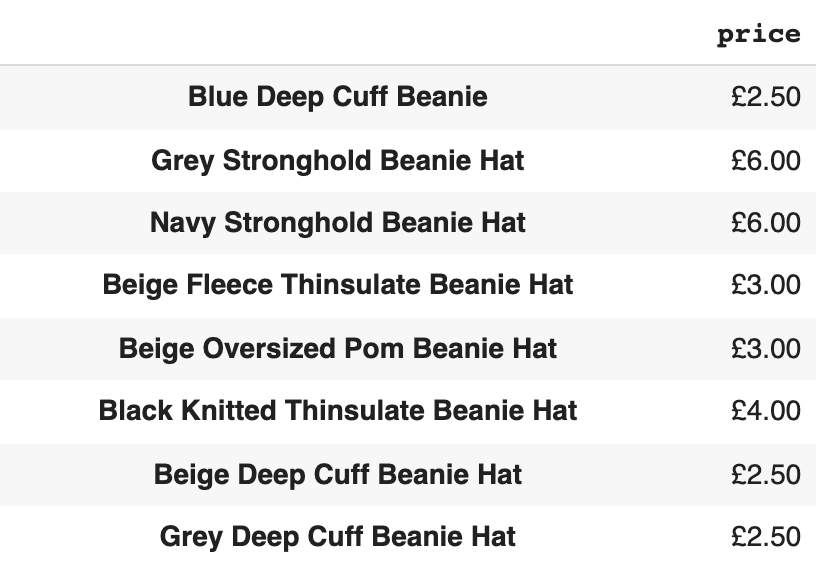

In [ ]:
url = "https://www.primark.com/en/search?text=beanie"
navigator = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1)'
html = requests.get(url, headers={'User-Agent': navigator})

soup = BeautifulSoup(html.text, 'html.parser')

#print(soup.prettify())

In [ ]:
bonnets = soup.find_all('li', {"class" : "product-listing__item product-item product-item--tall product-impression-item"})
prix = soup.find_all('div', {"class" : "product-item__price"})

In [ ]:
print (prix[1].text)
print (bonnets[1].find('p').text)


                        £6.00

                            Grey Stronghold Beanie Hat


In [ ]:
bonnets_dict = {}

for i in range(len(bonnets)):
  bonnet_name = bonnets[i].find('p').text
  bonnet_price = prix[i].text
  bonnets_dict[bonnet_name] = bonnet_price


In [ ]:
df_bonnets = pd.DataFrame(bonnets_dict.items(), columns=["Nom", "Prix"])
df_bonnets.head()

,Nom,Prix
0,\n Navy Stronghold ...,\n £6.00
1,\n Grey Stronghold ...,\n £6.00
2,\n Blue Deep Cuff B...,\n £2.50
3,\n Beige Deep Cuff ...,\n £2.50
4,\n Grey Deep Cuff B...,\n £2.50


In [ ]:
pd.set_option('display.max_colwidth', None)
df_bonnets["Nom"] = df_bonnets["Nom"].str.replace("\n", "")
df_bonnets["Prix"] = df_bonnets["Prix"].str.replace("\n", "")
df_bonnets

,Nom,Prix
0,Navy Stronghold Beanie Hat,£6.00
1,Grey Stronghold Beanie Hat,£6.00
2,Blue Deep Cuff Beanie,£2.50
3,Beige Deep Cuff Beanie Hat,£2.50
4,Grey Deep Cuff Beanie Hat,£2.50
5,Navy Deep Cuff Beanie Hat,£2.50
6,Black Deep Cuff Beanie Hat,£2.50
7,Black Super Soft Beanie Hat,£1.50
8,Beige Fleece Thinsulate Beanie Hat,£3.00
9,Beige Oversized Pom Beanie Hat,£3.00


<b><font color='orange'>Il y a 2 "Black Deep Cuff Beanie Hat" au même prix mais avec un visuel différent sur le site scrappé. Comme le nom est le même, ils se superposent dans le dictionnaire et un seul apparaît dans le dataframe. Je pense qu'il s'agit d'une erreur sur le site et que c'est donc une marge acceptable.</font></b>